In [1]:
import sys
sys.path.append("../../../") # Where to find utilssphering
import utilssphering
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,True,0.191908,60.000000,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.288099,2014937
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,False,0.269727,53.333333,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.320855,2014937
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,True,0.269617,62.222222,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.398249,2413350
3,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,False,0.329074,45.555556,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.389170,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.000142,True,0.205121,66.666667,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.363114,2381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,...,0.000583,False,0.628379,20.000000,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",6.976744,0.772160,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,True,0.139090,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.193171,452567
359,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,...,0.000014,False,0.666818,21.111111,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",9.302326,0.790813,452567
360,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,4.0,1,40,6,...,0.080201,True,0.193787,53.333333,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.234702,116595


In [3]:
def create_coordinate_array(rows, cols):
    """Will use coordinates to determine which plot should go where"""
    coordinates = []
    for i in range(rows):
        for j in range(cols):
            coordinates.append((i, j))
    return coordinates

vendor_micro_map = {
    "MolDev": "Molecular Devices\nImageXpress Micro Confocal",
    "Nikon": "Nikon Eclipse Ti2",
    "Yokogawa_US": "Yokogawa CV8000",
    "Yokogawa_Japan": "Yokogawa CQ1",
    "PE": "Revvity Opera Phenix Plus"
}


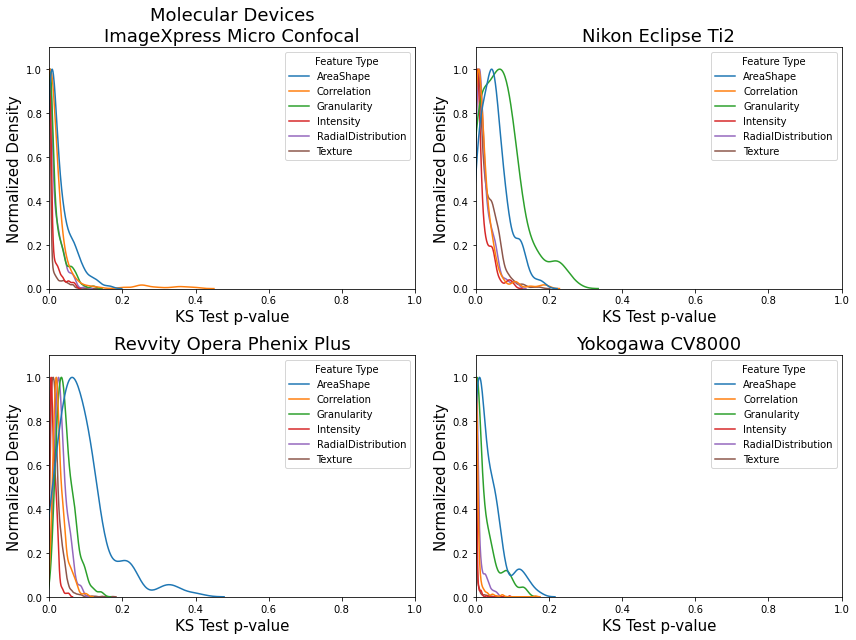

In [4]:
data_dir = "../../../data"

comparison_paths = sorted([os.path.join(root, file) for root, dirs, files in os.walk(data_dir) for file in files if file.endswith("all_plate_comparison.csv") and "Yokogawa_Japan" not in file])

num_rows, num_cols = 2, 2

coords = create_coordinate_array(num_rows, num_cols)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 9))

for i, pth in enumerate(comparison_paths):
    vendor_name = pth.split("/")[-1].split("_")[0]
    if vendor_name == "Yokogawa":
        vendor_name = vendor_name + "_" + pth.split("/")[-1].split("_")[1]
    vendor_name = vendor_micro_map[vendor_name]
    df = pd.read_csv(pth)

    # We will only compare between non-identical plates
    df = df[df["Assay_Plate_Barcode_plate1"] != df["Assay_Plate_Barcode_plate2"]]
    # Aggregate similar features
    agg_df = utilssphering.aggregate_comparison_pvalues(df, match_rep_df.columns, aggregate_rows=True, aggregate_similar_features=False)

    # Rename column for a better legend title (seems to be tricky to change seaborn legend titles)
    agg_df.rename(columns={"feature_type": "Feature Type"}, inplace=True)

    # Select columns with 'float64' dtype  
    float64_cols = list(agg_df.select_dtypes(include='float64'))
    # The same code again calling the columns. Convert to float32
    agg_df[float64_cols] = agg_df[float64_cols].astype('float32')

    utilssphering.plot_feature_density(
        agg_df,
        x="pvalue",
        group="Feature Type",
        fig=fig,
        ax=ax[coords[i]],
        plot_title=vendor_name,
        xlabel="KS Test p-value",
        ylabel="Normalized Density"
    )

# fig.savefig("(S11A)-feature_density.png", dpi=300)

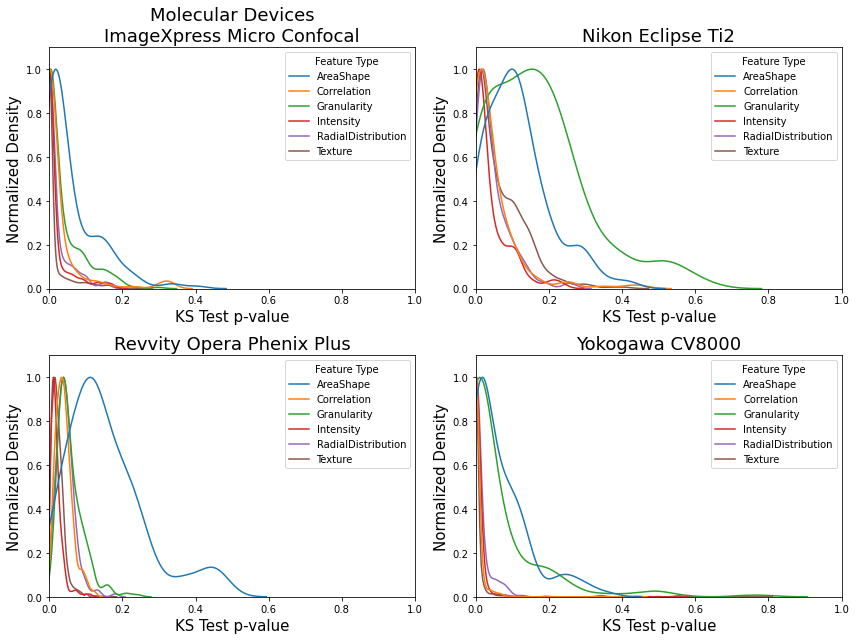

In [5]:
data_dir = "../../../data"

comparison_paths = sorted([os.path.join(root, file) for root, _, files in os.walk(data_dir) for file in files if file.endswith("all_plate_comparison_exclude_different_mag_binning_comparison.csv") and "Yokogawa_Japan" not in file])

num_rows, num_cols = 2, 2

coords = create_coordinate_array(num_rows, num_cols)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 9))

for i, pth in enumerate(comparison_paths):
    vendor_name = pth.split("/")[-1].split("_")[0]
    if vendor_name == "Yokogawa":
        vendor_name = vendor_name + "_" + pth.split("/")[-1].split("_")[1]
    vendor_name = vendor_micro_map[vendor_name]
    df = pd.read_csv(pth)

    # We will only compare between non-identical plates
    df = df[df["Assay_Plate_Barcode_plate1"] != df["Assay_Plate_Barcode_plate2"]]
    # Aggregate similar features
    agg_df = utilssphering.aggregate_comparison_pvalues(df, match_rep_df.columns, aggregate_rows=True, aggregate_similar_features=False)

    # Rename column for a better legend title (seems to be tricky to change seaborn legend titles)
    agg_df.rename(columns={"feature_type": "Feature Type"}, inplace=True)

    # Select columns with 'float64' dtype  
    float64_cols = list(agg_df.select_dtypes(include='float64'))
    # The same code again calling the columns. Convert to float32
    agg_df[float64_cols] = agg_df[float64_cols].astype('float32')

    utilssphering.plot_feature_density(
        agg_df,
        x="pvalue",
        group="Feature Type",
        fig=fig,
        ax=ax[coords[i]],
        plot_title=vendor_name,
        xlabel="KS Test p-value",
        ylabel="Normalized Density"
    )

# fig.savefig("(S11B)-feature_density-exclude-pixel-differences.png", dpi=300)

In [15]:
df["simultaneous-excitation_plate1"]

2     2.0
3     2.0
4     2.0
5     2.0
7     2.0
8     2.0
9     2.0
11    2.0
12    2.0
14    4.0
Name: simultaneous-excitation_plate1, dtype: float64

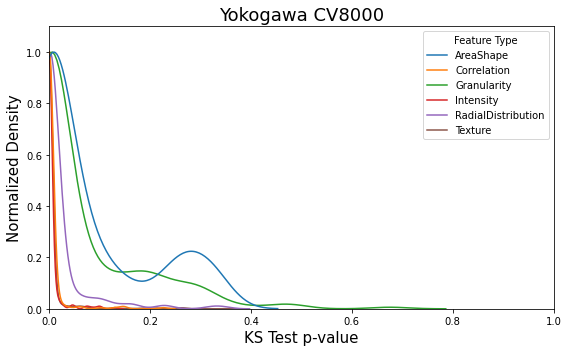

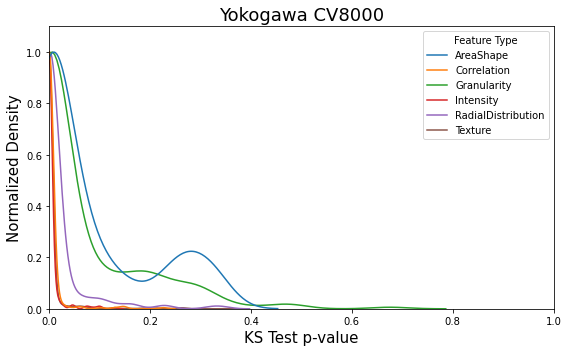

In [8]:
data_dir = "../../../data"

plot_df = pd.read_csv(os.path.join(data_dir, "Yokogawa_US_all_plate_comparison_exclude_different_mag_binning_comparison_exclude_simultaneous_excitation.csv"))

num_rows, num_cols = 1, 1

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 5))

vendor_name = vendor_micro_map["Yokogawa_US"]
df = pd.read_csv(pth)

# We will only compare between non-identical plates
plot_df = plot_df[plot_df["Assay_Plate_Barcode_plate1"] != plot_df["Assay_Plate_Barcode_plate2"]]
# Aggregate similar features
agg_df = utilssphering.aggregate_comparison_pvalues(plot_df, match_rep_df.columns, aggregate_rows=True, aggregate_similar_features=False)

# Rename column for a better legend title (seems to be tricky to change seaborn legend titles)
agg_df.rename(columns={"feature_type": "Feature Type"}, inplace=True)

# Select columns with 'float64' dtype  
float64_cols = list(agg_df.select_dtypes(include='float64'))
# The same code again calling the columns. Convert to float32
agg_df[float64_cols] = agg_df[float64_cols].astype('float32')

utilssphering.plot_feature_density(
    agg_df,
    x="pvalue",
    group="Feature Type",
    fig=fig,
    ax=ax,
    plot_title=vendor_name,
    xlabel="KS Test p-value",
    ylabel="Normalized Density"
)